In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log, pi, sqrt
from scipy.stats import multivariate_normal
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
#import pydotplus -> baixar esse cara
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import GridSearchCV

np.random.seed(12345)

# Regressão Logística

In [111]:
def yPred(w, x):
    yPred = 1/(1+np.exp(-x @ w))
    return yPred

def regLogGD(x, y, n_epochs, alpha):
    erroQM = []
    wPrev = np.zeros(x.shape[1]+1)
    aux = np.ones((x.shape[0], 1))
    x = np.hstack((aux, x))
    
    for epochs in range (0,n_epochs):
        suma = 0
        sumErro = 0
        for i in range(0, x.shape[0]):
            sumErro = sumErro + (y[i]-yPred(wPrev,x[i]))**2
            suma = suma +  (y[i]-yPred(wPrev,x[i]))*np.transpose(x[i])
        w = np.transpose(wPrev) + alpha*(1/x.shape[0])*suma
        erroEp = ((1/(2*x.shape[0]))*sumErro)
        erroQM.append(erroEp)
        wPrev = w
    return wPrev, erroQM

def predictLR(w, x):
    yPredito = []
    aux = np.ones((x.shape[0], 1))
    x = np.hstack((aux, x))
    for i in x:
        if(yPred(w,i)>=0.5):
            yPredito.append(1)
        else:
            yPredito.append(0)
    return yPredito

In [113]:
def accuracy(y, y_pred):
    tot = [1 for x,z in zip(y_test,results) if x == z]
    return (np.sum(np.array(tot))/len(y_test))*100

In [124]:
data = pd.read_csv("ex1.csv", header = None).values
lista = [[1,1],[1,0],[0,1],[2,4],[0.5,3],[0,0]]
X = data[:,0:-1]
Y = data[:,-1]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

In [128]:
w, erro = regLogGD(x_train, y_train, 1000, 0.001)
x_train.shape
results = predictLR(w, x_test)
print(np.array(results))
print(y_test)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0.
 1.]


In [129]:
tot = [1 for x,z in zip(y_test,results) if x == z]
(np.sum(np.array(tot))/len(y_test))


0.52

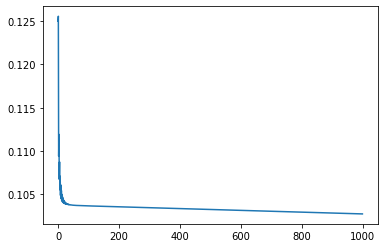

In [130]:
plt.plot(erro)

# Análise Discriminante Gaussiano (AGD)

In [1]:
def fit(x, y):
    classes, ocorrencs = np.unique(y, return_counts=True) # pegando as classes e ocorrencias
    numClasses = len(classes) # numero de classes
    n = len(y) # numero de linhas do dataset
    numFeatures = x.shape[1] # numero de colunas do dataset
    
    # Probabilidade das classes será proporcional a frequencia dessa classe no dataset
    probabilidadeClasses = dict(zip(classes, ocorrencs))
    for key in probabilidadeClasses:
        probabilidadeClasses[key] = probabilidadeClasses[key] / n
    
    media = np.zeros((numFeatures, numClasses)) # criando a lista da media das features por classe
    covar = np.zeros((numFeatures, numFeatures, numClasses)) # criando a lista de matrizes de correlação das features para cada classe

    for classe in classes:
        xk = x[y == classe] # pega as linhas em que classe é igual ao y -> que aí eu acesso essas linhas do x
        classe = int(classe)
        media[:, int(classe)] = np.mean(xk, axis=0)
        xi_mean = xk - media[:, int(classe)]
        covar[:, :, int(classe)] = (np.transpose(xi_mean) @ xi_mean)/len(xk)
        covar[:, :, int(classe)] += np.eye(numFeatures) * np.mean(np.diag(covar[:,:,classe]))  * 10 ** -6 # ver se assim ta certo, pq o do cesar ele botou uns numeros que eu nao entendi
    return {'media': media, 'covar': covar, 'classes': classes, 'numRows': n, 'numClasses': numClasses, 'numFeatures': numFeatures, 'probabilidadeClasses': probabilidadeClasses }
        
def predict(model, row):
    probabilits = np.zeros(model['numClasses'])
    for classe in model['classes']:
        classe = int(classe)
        fator1 = 1/(sqrt(np.linalg.det(model['covar'][:, :, classe])) * ((2*pi)**(model['numFeatures']/2)))
        
        inversa = np.linalg.inv(model['covar'][:, :, classe])
        difXMedia = row - model['media'][:, classe]
        z = (-0.5) * (np.transpose(difXMedia) @ inversa @ difXMedia) # valor que fica dentro do exp
        probabilits[classe] = fator1 * exp(z)
    return model['classes'][np.argmax(probabilits)]
    
    
# Função para um vetor de testes e então chama o predict
def getPredict(model, x_test):
    predicted = np.array([predict(model, row) for row in x_test])
    return predicted

# KNN

In [14]:
# Funções que realizam os cálculos de distância entre dois registros
def distance_euclidian(x1, x2):
    return sqrt(np.sum([abs(i - j) for i, j in zip(x1,x2)]))

def distance_manhattan(x1, x2):
    return np.sum([abs(i-j) for i, j in zip(x1,x2)])

def getClasses(y):
    return pd.array(data[:,-1]).unique()

# Função responsável por predizer a classe de um único registro
def predict1KNN(x, y, x_teste, k, function):
    classes = getClasses(y)
    results = []
    for i in range(0, x.shape[0]):
        results.append([function(x[i], x_teste), y[i]])
    results = sorted(results)
    dictClasses = {}
    for i in classes:
        dictClasses[i] = 0
    for i in range(0, k):
        for row in dictClasses.keys():
            if results[i][1] == row:
                dictClasses[row] += 1
    
    # retornar a chave que tem maior contagem
    minimus = [results[i][1] for i in range (0,k)]
    
    contClasses = [(x, minimus.count(x)) for x in set(minimus)]

    maximo = np.argmax(contClasses, axis=0)
    
    return contClasses[maximo[1]][0]

# Função utilizada para predizer as classes de um conjunto de registros
def predictKNN(x, y, x_test, k, function):
    yPredito = [predict1KNN(x, y, row, k, function) for row in x_test]
    return yPredito

In [15]:
data = pd.read_csv("ex1.csv", header = None).values
lista = [[1,1],[1,0],[0,1],[2,4],[0.5,3],[0,0]]
X = data[:,0:-1]
Y = data[:,-1]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

In [16]:
results = predictKNN(x_train, y_train, x_test, 5, distance_euclidian)

In [17]:
tot = [1 for x,z in zip(y_test,results) if x == z]
(np.sum(np.array(tot))/len(y_test))

0.84

# Árvore de Decisão

In [11]:
def calc_entropy(p):
    return - p * np.log2(p + 10 ** -6) - (1-p) * np.log2((1-p) + 10 ** -6)

def calc_gini(p):
    return 1 - p ** 2 - (1-p) ** 2

In [12]:
x, y = datasets.load_iris(return_X_y=True)
x = x[:,2:4]
np.random.seed(12345)

number_train = int(np.ceil(0.7*(x.shape[0])))
random_index = np.random.permutation(x.shape[0])
train_index = random_index[:number_train+1]
test_index = random_index[number_train+1:]

x_train = x[train_index]
x_test = x[test_index]
y_train = y[train_index]
y_test = y[test_index]

print("Número de padrões de treinamento: %d" % len(y_train))
print("Número de padrões de teste: %d" % len(y_test))

Número de padrões de treinamento: 106
Número de padrões de teste: 44


In [15]:
data_table = pd.DataFrame({'Brilho': [1.2, 1.1, 0.9, 0.8, 0.8, 0.9, 0.8, 0.8, 0.7],
                           'Tamanho': [23, 30, 36, 45, 38, 15, 20, 25, 25],
                           'Classe': [0, 0, 0, 0, 0, 1, 1, 1, 1]},
                   dtype='float')

display(data_table)
x = data_table.drop('Classe', axis=1).values
y = data_table['Classe'].values.astype("int")

labels = [0, 1]
label_names = ['Salmão', 'Seabass']
colors = ['green', 'blue']

,Brilho,Tamanho,Classe
0,1.2,23.0,0.0
1,1.1,30.0,0.0
2,0.9,36.0,0.0
3,0.8,45.0,0.0
4,0.8,38.0,0.0
5,0.9,15.0,1.0
6,0.8,20.0,1.0
7,0.8,25.0,1.0
8,0.7,25.0,1.0


In [16]:
tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(x, y)

pred = tree_classifier.predict(x)
pred

array([0, 0, 0, 0, 0, 1, 1, 1, 1])

In [19]:
dot_data = StringIO()
export_graphviz(tree_classifier, out_file=dot_data,  
                filled=True, rounded=True, feature_names=['Brilho', 'Tamanho'],
                special_characters=True, class_names=[str(l) for l in label_names])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree_salmao_seabass.png')
Image(graph.create_png())

NameError: name 'pydotplus' is not defined

# SVM

In [24]:
train_ratio = 0.8
validation_ratio = 0.2
x, y = datasets.make_circles(n_samples=300, noise=0.15, factor=0.5, random_state=12345)

In [25]:
model = svm.SVC(gamma='auto')
param_grid = [{'kernel': ['rbf'], 'C': 2 ** np.arange(-5.0, 16.0, 2),
                                  'gamma': 2 ** np.arange(-15.0, 4.0, 2)},
              {'kernel': ['poly'], 'C': 2 ** np.arange(-5.0, 16.0, 2),
                                   'degree': np.arange(2, 6)},
              {'kernel': ['linear'], 'C': 2 ** np.arange(-5.0, 16.0, 2)}]

model = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)

model.fit(x_train, y_train) 

support_vectors = model.best_estimator_.support_vectors_

print("Melhores hiperparâmetros:")
print(model.best_params_)
print("%d vetores suportes de %d dados de treinamento (%.2f%% dos exemplos)." \
      % (support_vectors.shape[0], x_train.shape[0], 100*support_vectors.shape[0]/x_train.shape[0]))

Melhores hiperparâmetros:
{'C': 0.5, 'gamma': 2.0, 'kernel': 'rbf'}
33 vetores suportes de 106 dados de treinamento (31.13% dos exemplos).


# Random Forest (Ensemble)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# kf = KFold(n_splits = 5, shuffle = True)
# ac = [];
# x = [1,5,10]
# #for i in x:
#     # Na linha abaixo, os parâmetros que passei para meu classificador foram, respectivamente:
#     # n_estimators (número de árvores), critério para avaliar a qualidade do split, máximo de colunas consideradas
#     # em cada split (raiz quadrada do número de colunas, que dá aprox. 7 features), profund. máx das árvores (10)
#     clf = RandomForestClassifier(i,"gini",7,10)
#     for result in kf.split(df):
#         train = df.iloc[result[0]]
#         test =  df.iloc[result[1]]
#         target_train = train[61]
#         target_test = test[61]
#         train = train.iloc[:, :59]
#         test = test.iloc[:, :59]
#         clf.fit(train, target_train)
#         target_pred = clf.predict(test)
#         ac.append(accuracy_score(target_test, target_pred))
#     print("Árvores: %d" %i)
#     print("Scores: ")
#     print(ac)
#     print("Acurácia: %f " %(mean(ac)))
#     print("\n")
#     ac = []



num_arvores = 10
max_columns = 3
max_profundidade = 10
clf = RandomForestClassifier(num_arvores,"gini",max_columns,max_profundidade)
clf.fit(train, target_train)
clf.predict(test)